In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import wrangle
import explore

import warnings
warnings.filterwarnings("ignore")

# Notebook for documenting Zillow project data preparation and exploration work:
- Goal is to predict home value (tax_value)
- Initially just using number of bedrooms, bathrooms, and square footage to predict
- Drop outliers and nulls

## Once MVP complete, additional items to test:
- Imputing nulls (mean, median, or maybe based on bedroom and bathroom number) 
- Additional features from database
- Outlier handling:
    - Using RobustScaler or QuatileScaler to include outliers
    - Removing outliers by train, validate, test sets and not just the whole dataset
    - Including outliers
- Additional features to add and engineer
- Feature selection


In [2]:
df = wrangle.wrangle_zillow()

Using cached data


In [3]:
df.shape

(52442, 5)

In [4]:
df.isna().sum()

bedroom         0
bathroom        0
square_feet    82
tax_value       1
fips            0
dtype: int64

In [5]:
# Convert bedrooms to integer type
df.bedroom = df.bedroom.astype('int')

# Univariate exploration

### Box Plots

In [6]:
features_to_plot = ['bedroom', 'bathroom', 'square_feet', 'tax_value']

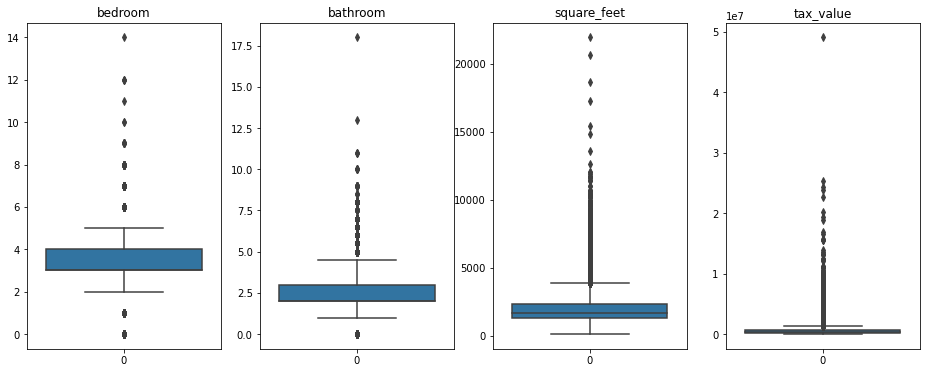

In [7]:
explore.plot_boxplots(df, features_to_plot)

## Takeaways:
- Some outliers for bedroom and bathroom but for the most part clustered between 2-4
- Lots of square footage outliers
- Very high outliers for tax value makes it difficult to visualize the lower end of home values, where most observations look to be

### Histograms

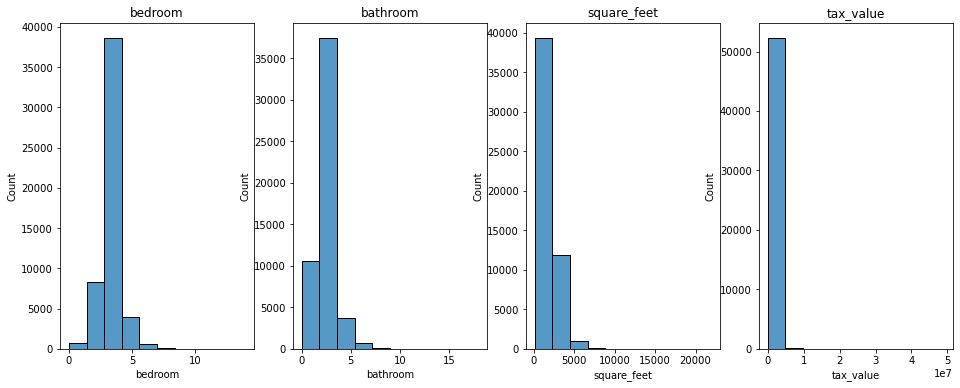

In [8]:
explore.plot_histograms(df, features_to_plot)

## Takeaways:
- Fairly normal distribution for bedroom and bathroom
- Square footage and tax_value look very skewed to the left due to some very high outliers

### Will drop outliers going forward for this MVP

In [9]:
# using a setting of 3 to keep as much data as possible
df_outlier_removed = wrangle.remove_outliers(df, 3, ['bathroom','bedroom','square_feet','tax_value'])

Number of observations removed: 1772


In [10]:
df_outlier_removed.shape

(50670, 5)

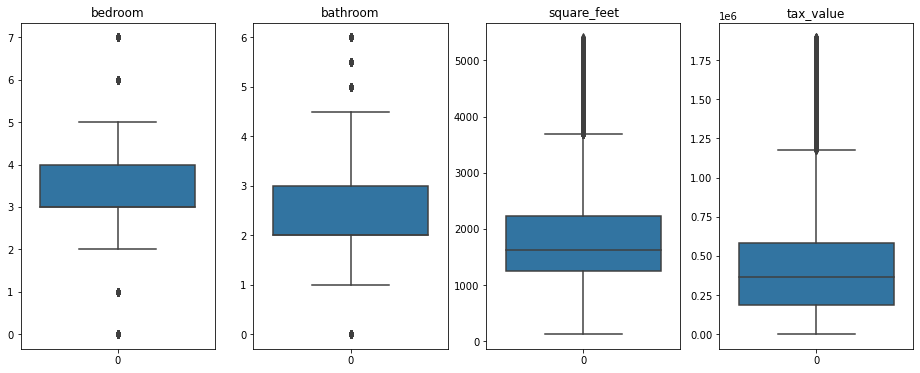

In [11]:
explore.plot_boxplots(df_outlier_removed, ['bedroom', 'bathroom', 'square_feet', 'tax_value'])

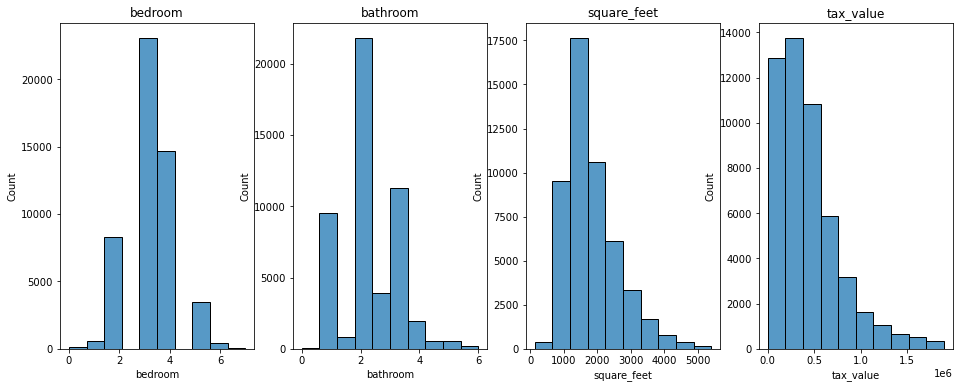

In [12]:
explore.plot_histograms(df_outlier_removed, ['bedroom', 'bathroom', 'square_feet', 'tax_value'])

### With outliers removed:
- Relatively normal distributions for bedrooms, bathrooms, and square feet
- Left skewed for tax_value

In [13]:
df_outlier_removed.shape

(50670, 5)

In [14]:
# For MVP will just drop rows with NA. For the df with outliers removed this represents 55 rows of 50669 or <0.2%
df = df_outlier_removed.dropna()


In [15]:
df.shape

(50615, 5)

### Property locations

In [16]:
def get_locations_from_fips(fip):
    if int(fip) == 6037:
        return "Los Angeles County"
    if int(fip) == 6059:
        return "Orange County"
    if int(fip) == 6111:
        return "Ventura County"

In [17]:
df["county"] = df.fips.apply(lambda x: get_locations_from_fips(x))

In [18]:
df.county.value_counts()

Los Angeles County    32709
Orange County         13607
Ventura County         4299
Name: county, dtype: int64

## Splitting data going forward to explore multivariate relationships

In [19]:
train, validate, test = wrangle.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [20]:
train.shape

(28344, 6)

In [21]:
train.columns

Index(['bedroom', 'bathroom', 'square_feet', 'tax_value', 'fips', 'county'], dtype='object')

In [22]:
def bedroom_mapper(num):
    """ Map the number of bedrooms to a categorical label """
    if num <= 2:
        return "2_or_less"
    elif num <=3:
        return "3"
    elif num > 3:
        return "more_than_3"

In [23]:
def bathroom_mapper(num):
    """ Map the number of bathrooms to a categorical label """
    if num == 2:
        return "2"
    elif num < 2:
        return "less_than_2"
    elif num > 2:
        return "more_than_2"

In [24]:
train["bedroom_cat"] = train.bedroom.apply(lambda row: bedroom_mapper(row))
validate["bedroom_cat"] = validate.bedroom.apply(lambda row: bedroom_mapper(row))
test["bedroom_cat"] = test.bedroom.apply(lambda row: bedroom_mapper(row))

In [25]:
train["bathroom_cat"] = train.bathroom.apply(lambda row: bathroom_mapper(row))
validate["bathroom_cat"] = validate.bathroom.apply(lambda row: bathroom_mapper(row))
test["bathroom_cat"] = test.bathroom.apply(lambda row: bathroom_mapper(row))

#### Adding columns to simplify bedroom and bathroom counts as categoricals:
- Bedrooms: 3, more than 3, 2 or less
- Bathrooms: 2, more than 2, less than 2

In [26]:
# train["bedroom_cat"] = pd.qcut(train.bedroom,q = 3, labels = ['bedrooms_3_or_less','bedrooms_4','bedrooms_over_4'])

In [27]:
# train["bathroom_cat"] = pd.qcut(train.bathroom,3, labels = ['bathrooms_2_or_less','bathrooms_2_5','bathrooms_over_2_5'])

Generating plots tax_value by bedroom_cat


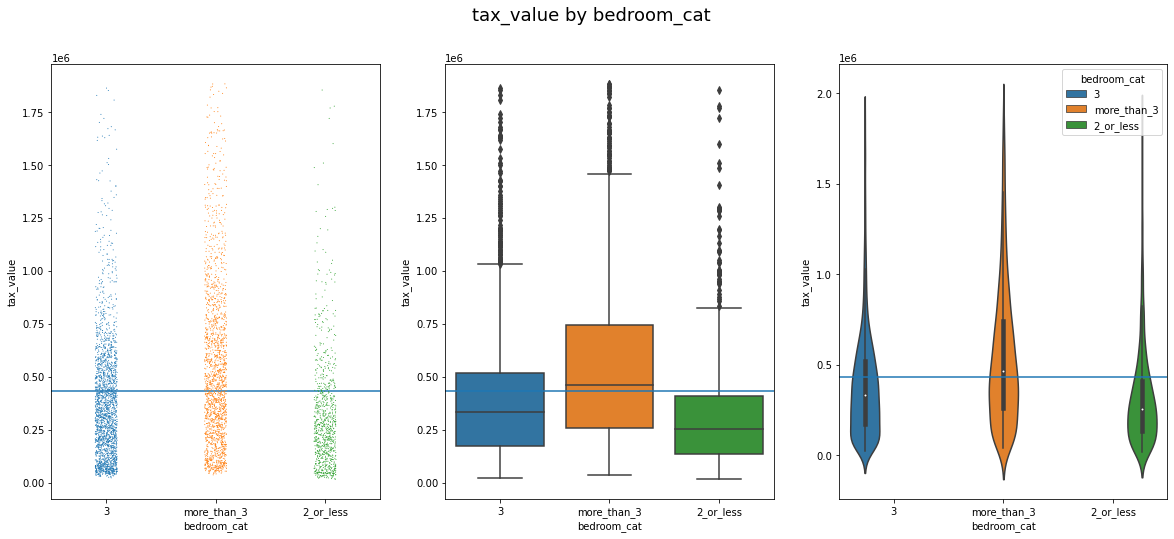

Generating plots tax_value by bathroom_cat


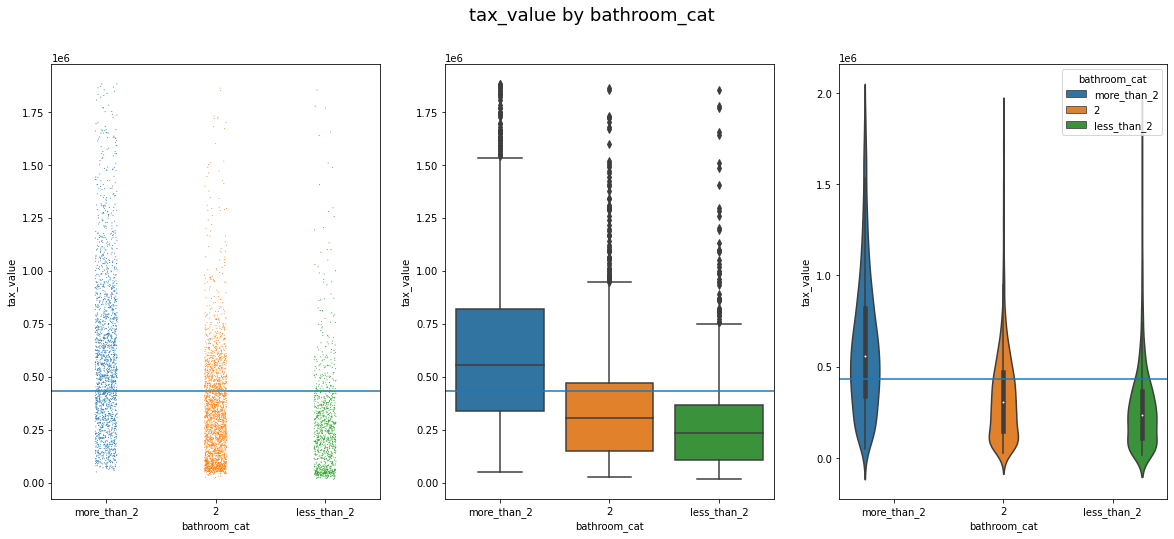

In [28]:
explore.plot_categorical_and_continuous_vars(train, ['bedroom_cat','bathroom_cat'], ['tax_value'], sample_amt = 5000)

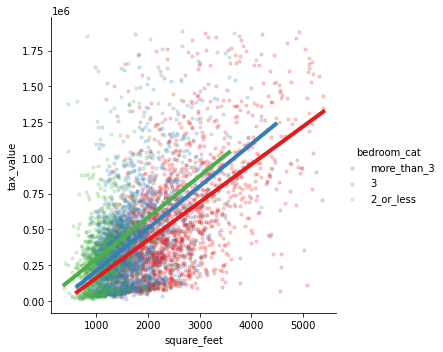

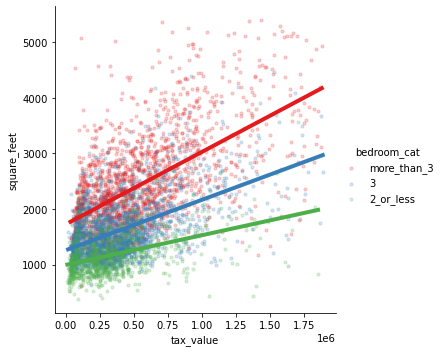

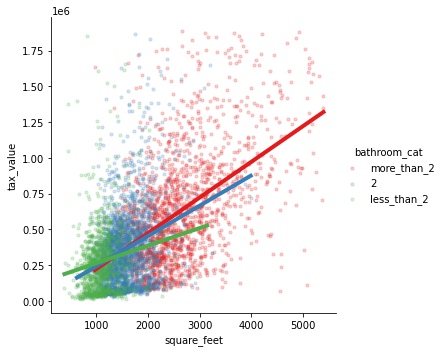

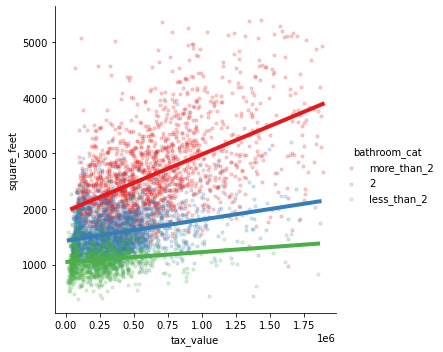

In [29]:
explore.plot_variable_pairs(train, ['square_feet','tax_value'], categoricals = ['bedroom_cat','bathroom_cat'], sample_amt=5000)

### Takeaways:
- Average tax value looks to be higher than the overall average for more than 3 bedrooms and lower for 3 or less:
    - check with 1 sample t test for all 3 categories
- Average tax value looks to be higher than the overall average for more than 2 bathrooms and lower for 2 or less
    - check with 1 sample t test for all 3 categories
- Seems to be a linear relationship between square feet and tax value
- Bedroom count does not have a great effect on the square feet to tax value relationship
- Bathroom count also does not have a great effect on the square feet to tax value relationship but there is a little more variation in the slope of the lines 

### Statistical tests of tax values depending on bedroom and bathroom count category
- all 1 sample t test to check the category average tax value vs the overall
- will check if significantly higher or lower depending on 2-tailed test result
- assumptions for t-test will be checked prior to performing test -> all categories have >> 30 samples
- $H_0$ for all is that the category average is not significantly different from the overall average
- alpha value is 0.05 for all

In [30]:
alpha = 0.05

### Start with bedroom category

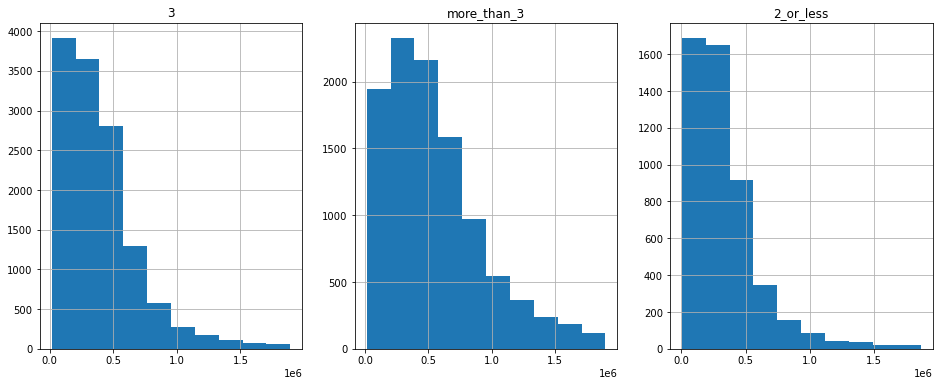

In [31]:
plt.figure(figsize=(16,6))
for i, bed_cat in enumerate(set(train.bedroom_cat)):
    plt.subplot(1, 3, i+1)
    plt.title(bed_cat)
    train.tax_value[train.bedroom_cat == bed_cat].hist()

### Approximately normal distribution but very much skewed to the left

In [32]:
for bed_cat in set(train.bedroom_cat):
    sample = train.tax_value[train.bedroom_cat == bed_cat]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    print(bed_cat, round(t,2), "Significant (2-tail)?", p < alpha)
print("-----------")
for bed_cat in set(train.bedroom_cat):
    sample = train.tax_value[train.bedroom_cat == bed_cat]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='greater')
    if p/2 < alpha:
        print(bed_cat, round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='less')
    
    if p/2 < alpha:
        print(bed_cat, round(t,2), "Significantly Less")

3 -17.63 Significant (2-tail)? True
more_than_3 29.09 Significant (2-tail)? True
2_or_less -26.99 Significant (2-tail)? True
-----------
3 -17.63 Significantly Less
more_than_3 29.09 Significantly Greater
2_or_less -26.99 Significantly Less


### Based on t-test, 3 or fewer bedrooms tax values are significantly less than the average, while more than 3 is signficantly more

### Moving on to bathrooms

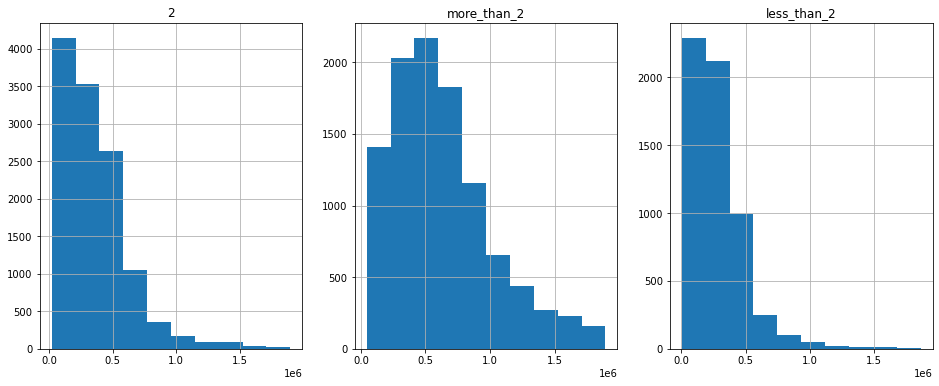

In [33]:
plt.figure(figsize=(16,6))
for i, bath_cat in enumerate(set(train.bathroom_cat)):
    plt.subplot(1, 3, i+1)
    plt.title(bath_cat)
    train.tax_value[train.bathroom_cat == bath_cat].hist()

### Approximately normal distribution but very much skewed to the left

In [34]:
for bath_cat in set(train.bathroom_cat):
    sample = train.tax_value[train.bathroom_cat == bath_cat]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    print(bath_cat, round(t,2), "Significant (2-tail)?", p < alpha)
print("-----------")
for bath_cat in set(train.bathroom_cat):
    sample = train.tax_value[train.bathroom_cat == bath_cat]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='greater')
    if p/2 < alpha:
        print(bath_cat, round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='less')
    
    if p/2 < alpha:
        print(bath_cat, round(t,2), "Significantly Less")

2 -33.81 Significant (2-tail)? True
more_than_2 50.16 Significant (2-tail)? True
less_than_2 -56.29 Significant (2-tail)? True
-----------
2 -33.81 Significantly Less
more_than_2 50.16 Significantly Greater
less_than_2 -56.29 Significantly Less


## Based on t-test, 2 or fewer bathrooms have tax values significantly lower than the overall average while greater than 2 bathrooms results in higher than average values

### Analyzing correlation between variables

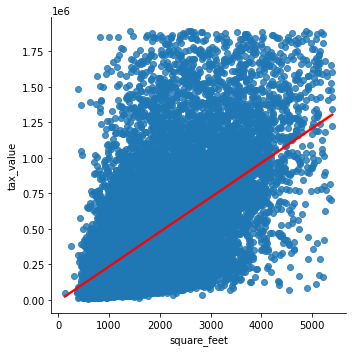

In [35]:
sns.lmplot(data = train, x= 'square_feet', y='tax_value', line_kws={'color':'red'})

### Looks like a fairly linear relationship between square footage and tax value

### Does the ratio of bedrooms to bathrooms have any effect on tax value?

In [36]:
# Do have some 0 values for num of bathrooms, so replace these with 0
train["bed_to_bath"] = (train.bedroom/train.bathroom).replace(np.inf, 0).fillna(0)
validate["bed_to_bath"] = (validate.bedroom/validate.bathroom).replace(np.inf, 0).fillna(0)
test["bed_to_bath"] = (test.bedroom/test.bathroom).replace(np.inf, 0).fillna(0)

In [37]:
r, p = stats.pearsonr(train.bed_to_bath, train.tax_value)
print("p<alpha: ", p<alpha, ",correlation: ", r, "weak negative")

p<alpha:  True ,correlation:  -0.3012465827067521 weak negative


## Check correlation of all variables to target

In [38]:
linear_correlation = pd.DataFrame({"Tax Value":train.corrwith(train.tax_value,method='pearson')}).sort_values(by='Tax Value',ascending=False)

In [39]:
non_linear_correlation = pd.DataFrame({"Tax Value":train.corrwith(train.tax_value,method='spearman')}).sort_values(by='Tax Value',ascending=False)

<AxesSubplot:title={'center':'Check for Linear Correlation'}>

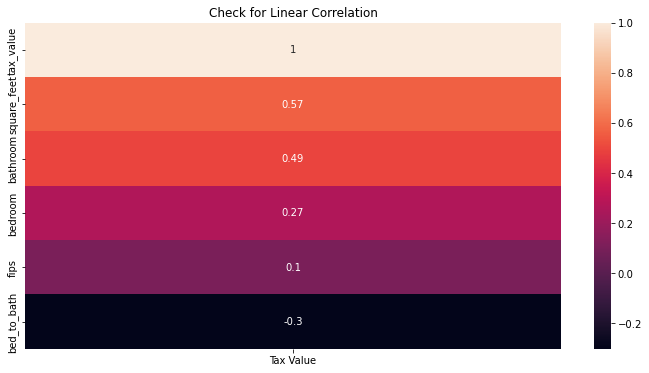

In [40]:
plt.figure(figsize=(12,6))
plt.title("Check for Linear Correlation")
sns.heatmap(linear_correlation, annot=True)

<AxesSubplot:title={'center':'Non-Linear Correlation'}>

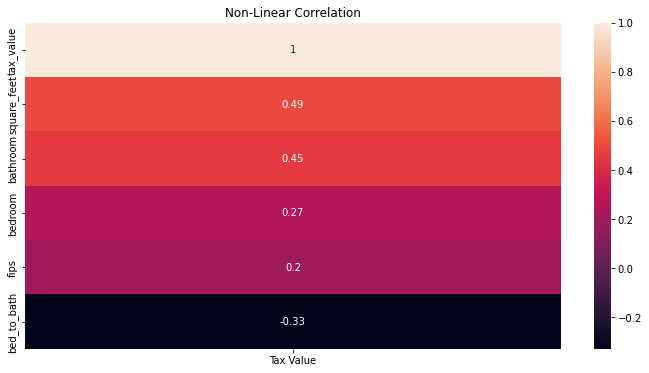

In [41]:
plt.figure(figsize=(12,6))
plt.title("Non-Linear Correlation")
sns.heatmap(non_linear_correlation, annot=True)

### Takeaways:
- Relatively high correlation with square footage and bathroom count:
    - As these two values increase, home value does as well
- Weak correlation between bedroom count and tax value
- No variable here has very high correlation - other factors must influence

# Modeling

### Prepare datasets per curriculum

#### Dummy variables for categoricals

In [42]:
X_train_exp = pd.get_dummies(train, columns = ['bedroom_cat','bathroom_cat'], drop_first=True)

In [43]:
X_train_exp.head()

,bedroom,bathroom,square_feet,tax_value,fips,county,bed_to_bath,bedroom_cat_3,bedroom_cat_more_than_3,bathroom_cat_less_than_2,bathroom_cat_more_than_2
19064,2,1.0,731.0,280283.0,6037.0,Los Angeles County,2.000000,0,0,1,0
18139,3,2.0,1846.0,624324.0,6059.0,Orange County,1.500000,1,0,0,0
36767,5,3.0,3456.0,721504.0,6037.0,Los Angeles County,1.666667,0,1,0,1
43596,3,2.0,2104.0,1480813.0,6037.0,Los Angeles County,1.500000,1,0,0,0
14521,4,2.0,1735.0,436897.0,6059.0,Orange County,2.000000,0,1,0,0


In [45]:
columns_to_use = ['square_feet']

In [46]:
X_train = X_train_exp[columns_to_use]
X_validate = pd.get_dummies(validate, columns = ['bedroom_cat','bathroom_cat'], drop_first=True)[columns_to_use]
X_test = pd.get_dummies(test, columns = ['bedroom_cat','bathroom_cat'], drop_first=True)[columns_to_use]

In [47]:
X_train.columns

Index(['square_feet'], dtype='object')

In [48]:
features_to_scale = ['square_feet']

In [49]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.scale_data(X_train, X_validate, X_test,features_to_scale)

In [50]:
X_train_scaled

,square_feet_scaled
19064,0.114465
18139,0.326120
36767,0.631739
43596,0.375095
14521,0.305049
...,...
14180,0.418375
33156,0.254935
52129,0.498102
23381,0.346052


In [51]:
y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

(array([7261., 7670., 6010., 3285., 1736.,  912.,  606.,  382.,  285.,
         197.]),
 array([   3254. ,  192415.2,  381576.4,  570737.6,  759898.8,  949060. ,
        1138221.2, 1327382.4, 1516543.6, 1705704.8, 1894866. ]),
 <BarContainer object of 10 artists>)

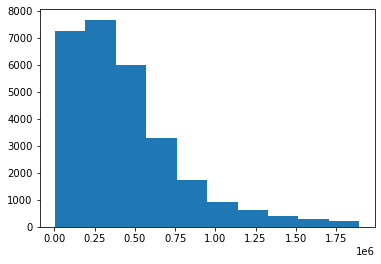

In [52]:
plt.hist(y_train)

In [53]:
predictions = pd.DataFrame({
    'actual': validate.tax_value
})

## Baseline

In [54]:
# 1. Predict tax_value_pred_mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax_value_pred_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  342421.44 
Validate/Out-of-Sample:  340698.19
RMSE using Median
Train/In-Sample:  350836.29 
Validate/Out-of-Sample:  348418.79


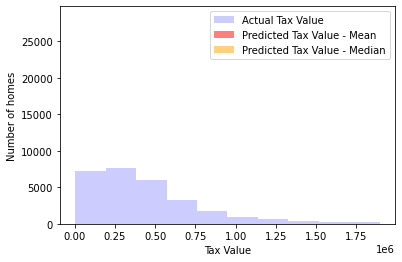

In [55]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.2, label="Actual Tax Value")
plt.hist(y_train.tax_value_pred_mean, bins=1, color='red', alpha=.5, rwidth=1171100, label="Predicted Tax Value - Mean")
plt.hist(y_train.tax_value_pred_median, bins=1, color='orange', alpha=.5, rwidth=1171100, label="Predicted Tax Value - Median")
plt.xlabel("Tax Value")
plt.ylabel("Number of homes")
plt.legend()
plt.show()


In [56]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  282260.3762806001 
Validation/Out-of-Sample:  283322.81292209233


In [57]:
# create the model object
lars = LassoLars(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for OLS using LarsLasso\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)



RMSE for OLS using LarsLasso
Training/In-Sample:  282260.4264895558 
Validation/Out-of-Sample:  283321.4364813908


In [58]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  342421.4367794234 
Validation/Out-of-Sample:  340698.1910143057


### Polynomial Features

In [59]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)


In [60]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  281559.5460444788 
Validation/Out-of-Sample:  282499.07399518986


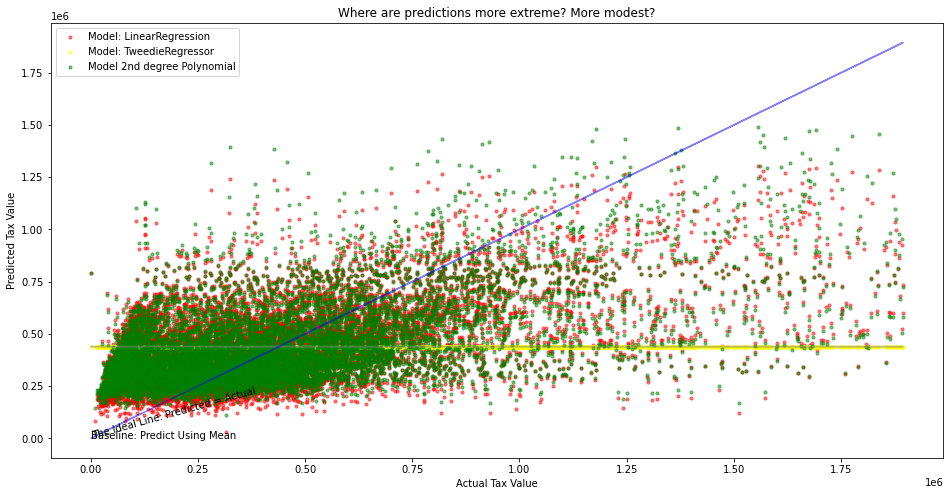

In [61]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=10, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=10, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.5, color="green", s=10, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


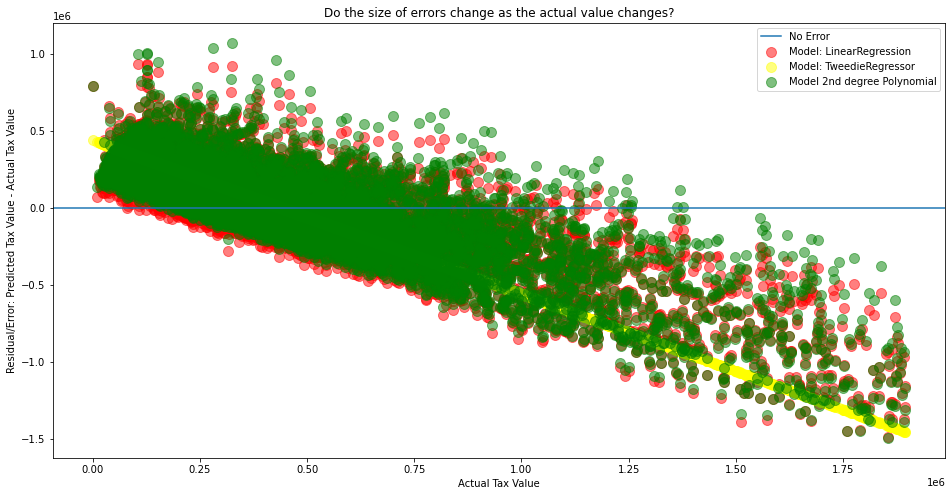

In [62]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2-y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

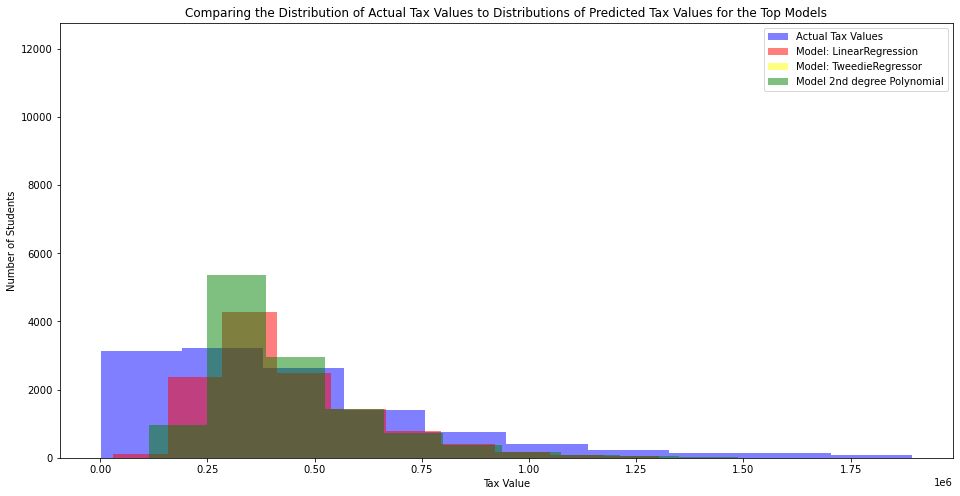

In [63]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()


In [64]:
y_validate

,tax_value,tax_value_pred_mean,tax_value_pred_median,tax_value_pred_lm,tax_value_pred_lars,tax_value_pred_glm,tax_value_pred_lm2
16178,117594.0,438813.394687,362435.0,334059.786879,334150.759852,438813.394687,333332.058778
20041,34948.0,438813.394687,362435.0,262105.747892,262259.209146,438813.394687,274989.563913
27432,251031.0,438813.394687,362435.0,334302.874848,334393.636712,438813.394687,333535.589634
11703,395572.0,438813.394687,362435.0,412334.113073,412357.108930,438813.394687,401106.009825
43928,735000.0,438813.394687,362435.0,373683.125915,373739.688112,438813.394687,367079.080981
...,...,...,...,...,...,...,...
5786,154037.0,438813.394687,362435.0,503735.189624,503678.808476,438813.394687,485925.818356
36631,685000.0,438813.394687,362435.0,412334.113073,412357.108930,438813.394687,401106.009825
32643,644944.0,438813.394687,362435.0,558673.070742,558568.978947,438813.394687,539852.447269
24987,367965.0,438813.394687,362435.0,296867.327538,296990.600196,438813.394687,302701.779241


In [65]:
pd.concat([
    y_validate.apply(lambda col: r2_score(y_validate.tax_value, col)).rename('r2'),
    y_validate.apply(lambda col: mean_squared_error(y_validate.tax_value, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(lambda x: x**0.5)
)

,r2,mse,rmse
tax_value,1.000000,0.000000e+00,0.000000
tax_value_pred_mean,-0.000097,1.160753e+11,340698.191014
tax_value_pred_median,-0.045937,1.213957e+11,348418.785939
tax_value_pred_lm,0.308383,8.027182e+10,283322.812922
tax_value_pred_lars,0.308390,8.027104e+10,283321.436481
tax_value_pred_glm,-0.000097,1.160753e+11,340698.191014
tax_value_pred_lm2,0.312399,7.980573e+10,282499.073995


# Predict on Test

In [66]:
# y_test = pd.DataFrame(y_test)

# # predict on test
# y_test['tax_value_pred_lm'] = lm.predict(X_test)

# # evaluate: rmse
# rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm)**(1/2)

# print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)
